# Data Formatting and EDA
---
This notebook breaks down the raw data taken from the Recreation Information Database. It aggregates campground reservations by date and Facility ID, the seperates the dataset into certain selected campgrounds.

- [Loading the Data](#Load-and-Format-the-Data)
- [Testing Fields](#Testing-Fields)
- [Site Aggregation](#Site-Aggregation-For-Modeling)
- [Combined Data EDA and Preprocessing](#Combined-Data-EDA-and-Preprocessing)
- [Site Aggregation](#Site-Aggregation-For-Modeling)

In [2]:
import chardet
import numpy as np
import pandas as pd
import datetime
import codecs

import os
import glob

import progressbar
from time import sleep

import matplotlib.pyplot as plt
import seaborn as sns

## Load and Format the Data
---

**NOTE:** Each raw dataset was run individually through this process, as they can take up multiple gigabytes of memory.

In [3]:
# specify filename to load for processing and aggregation
filename = '../data/Raw-Data/reservations2014.csv'

In [4]:
# define fucntion to find the memory usage of a pandas object
def mem_usage(pandas_obj):
    # check object for df
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [5]:
# attempt to load the data using various codecs
types_of_encoding = ["utf8", "cp1252"]
for encoding_type in types_of_encoding:
    with codecs.open(filename, encoding = encoding_type, errors ='replace') as csvfile:
        rez = pd.read_csv(csvfile)

In [6]:
# function to format the imported data, drop all categories of reservations except campsites
def nps_site_format(df):
    # get only reservations from the National Park Service, OrdID of 128
    df = df[df['OrgID'] == 128]
    
    # get only site type entities
    df = df[df['EntityType'] == 'Site']
    
    # convert date columns to datetime, y-m-d
    df['EndDate'] = pd.to_datetime(df['EndDate'], format= '%Y-%m-%d')
    df['StartDate'] = pd.to_datetime(df['StartDate'], format= '%Y-%m-%d')
    df['OrderDate'] = pd.to_datetime(df['OrderDate'], format= '%Y-%m-%d')
    
    # calculate the stay length of the reservation
    df['StayLen'] = df['EndDate'] - df['StartDate']
    df['StayLen'] = df['StayLen'].dt.days + 1
    
    # calculate the days in advance the resveration was made
    # note: some reservations were recorded after the start date, those values are imputed as zero
    df['BookingHorizon'] = df['StartDate'] - df['OrderDate']
    df['BookingHorizon'] = df['BookingHorizon'].dt.days.clip(lower=0)
    
    # calculate the daily rate for each reservation
    df['DailyRate'] = df['TotalBeforeTax'] / df['StayLen']
    
    # fill nulls in fee columns with zeroes
    df[['UseFee', 'TranFee', 'AttrFee']] = df[['UseFee', 'TranFee', 'AttrFee']].fillna(0)
    
    # drop facility attribute columns
    df = df.drop(axis = 1, columns = ['FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'UseType',
                                      'CustomerZIP', 'CustomerState', 'CustomerCountry', 'FacilityZIP', 'EntityID'])
    
    # drop categorical columns
    df = df.drop(axis = 1, columns = ['Tent', 'Popup', 'Trailer', 
                              'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 
                              'Van', 'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 
                              'Bus', 'Bicycle', 'Snowmobile', 'OffRoadlAllTerrainVehicle', 
                              'PowerBoat', 'PickupCamper', 'LargeTentOver9x12', 'SmallTent', 'Marinaboat'])
    
    # drop nulls in important columns
    df = df.dropna(axis = 0, subset = ['FacilityID', 'StartDate', 'EndDate'])
    
    # drop duplicate order numbers
    df = df.drop_duplicates(['OrderNumber'])
    
    return df

In [7]:
# view the shape of rez
rez.shape

(2654437, 56)

In [8]:
# format imported data
rez = nps_site_format(rez)

In [9]:
# view the shape of formated rez
rez.shape

(449046, 28)

In [10]:
rez.describe()

,HistoricalReservationID,OrgID,ParentLocationID,LegacyFacilityID,ProductID,FacilityID,Tax,UseFee,TranFee,AttrFee,TotalBeforeTax,TotalPaid,NumberOfPeople,StayLen,BookingHorizon,DailyRate
count,4.490460e+05,449046.0,449046.000000,449046.000000,449046.000000,449046.000000,449046.0,449046.000000,449046.000000,449046.000000,449046.000000,449046.000000,449046.000000,449046.000000,449046.000000,449046.000000
mean,1.630043e+09,128.0,74317.484777,74063.764583,234459.237227,233331.200523,0.0,36.819264,1.818651,0.229326,39.475188,39.476579,4.397055,3.288342,64.608332,11.828373
std,7.389484e+07,0.0,19.967217,8965.146544,56021.873974,2873.918314,0.0,45.423301,4.249561,3.224915,44.624556,44.625904,8.727256,1.714692,65.521091,14.207190
min,1.500638e+09,128.0,74266.000000,70851.000000,139983.000000,232432.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.560651e+09,128.0,74324.000000,70930.000000,203077.000000,232452.000000,0.0,18.000000,0.000000,0.000000,18.000000,18.000000,2.000000,2.000000,7.000000,7.666667
50%,1.629017e+09,128.0,74325.000000,70970.000000,205451.000000,232489.000000,0.0,25.000000,0.000000,0.000000,29.000000,29.000000,3.000000,3.000000,39.000000,10.000000
75%,1.691902e+09,128.0,74327.000000,72159.000000,281074.000000,233241.000000,0.0,45.000000,0.000000,0.000000,46.000000,46.000000,5.000000,4.000000,122.000000,13.333333
max,1.759446e+09,128.0,74330.000000,114702.000000,372022.000000,250796.000000,0.0,1476.000000,85.000000,168.000000,1476.000000,1476.000000,600.000000,31.000000,722.000000,770.000000


In [11]:
rez.isnull().sum()

HistoricalReservationID    0
OrderNumber                0
Agency                     0
OrgID                      0
CodeHierarchy              0
RegionCode                 0
RegionDescription          0
ParentLocationID           0
ParentLocation             0
LegacyFacilityID           0
Park                       0
SiteType                   0
ProductID                  0
EntityType                 0
FacilityID                 0
Tax                        0
UseFee                     0
TranFee                    0
AttrFee                    0
TotalBeforeTax             0
TotalPaid                  0
StartDate                  0
EndDate                    0
OrderDate                  0
NumberOfPeople             0
StayLen                    0
BookingHorizon             0
DailyRate                  0
dtype: int64

In [12]:
rez.dtypes

HistoricalReservationID             int64
OrderNumber                        object
Agency                             object
OrgID                               int64
CodeHierarchy                      object
RegionCode                         object
RegionDescription                  object
ParentLocationID                    int64
ParentLocation                     object
LegacyFacilityID                    int64
Park                               object
SiteType                           object
ProductID                           int64
EntityType                         object
FacilityID                        float64
Tax                               float64
UseFee                            float64
TranFee                           float64
AttrFee                           float64
TotalBeforeTax                    float64
TotalPaid                         float64
StartDate                  datetime64[ns]
EndDate                    datetime64[ns]
OrderDate                  datetim

In [13]:
# find average memory usage for each column type
for dtype in ['float','int','object']:
    selected_dtype = rez.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 3.43 MB
Average memory usage for int columns: 3.43 MB
Average memory usage for object columns: 28.17 MB


In [14]:
# check memory usage for int columns
# downcast ints
rez_int = rez.select_dtypes(include=['int'])
converted_int = rez_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(rez_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([rez_int.dtypes, converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

3.43 MB
3.43 MB


,before,after


In [15]:
# check memory usage for float columns
# reduce to downcast float to save memory
rez_float = rez.select_dtypes(include=['float'])
converted_float = rez_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(rez_float))
print(mem_usage(converted_float))
compare_floats = pd.concat([rez_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

37.69 MB
20.56 MB


,before,after
float32,NaN,10.0
float64,10.0,NaN


In [16]:
# check memory usage for entire dataset
# copy to omptimized dataframe
optimized_rez = rez.copy()
optimized_rez[converted_int.columns] = converted_int
optimized_rez[converted_float.columns] = converted_float
print(mem_usage(rez))
print(mem_usage(optimized_rez))

346.79 MB
329.66 MB


In [17]:
# save 
rez.to_csv("../Data/Cleaned-Data/nps_res_2014.csv", index = False)
optimized_rez.to_csv("../Data/Cleaned-Data/nps_optimized_2014.csv", index = False)

In [18]:
optimized_rez.dtypes

HistoricalReservationID             int64
OrderNumber                        object
Agency                             object
OrgID                               int64
CodeHierarchy                      object
RegionCode                         object
RegionDescription                  object
ParentLocationID                    int64
ParentLocation                     object
LegacyFacilityID                    int64
Park                               object
SiteType                           object
ProductID                           int64
EntityType                         object
FacilityID                        float32
Tax                               float32
UseFee                            float32
TranFee                           float32
AttrFee                           float32
TotalBeforeTax                    float32
TotalPaid                         float32
StartDate                  datetime64[ns]
EndDate                    datetime64[ns]
OrderDate                  datetim

## Testing Fields
---

This section of the notebook is to ensure the aggregation functions wil work as expected. Aggregating the data takes a long period of time and this ensured that the data would mostly remain intact.

In [22]:
# create list of dates to aggregate on
datelist = pd.date_range(optimized_rez['StartDate'].min(), optimized_rez['EndDate'].max()).tolist()
jan_1 = datelist[datelist.index(pd.Timestamp('2014-08-04'))]
print(jan_1.date())
jan_1_filter = (optimized_rez['StartDate'] <= jan_1) & (optimized_rez['EndDate'] >= jan_1)

2014-08-04


In [23]:
# establish the groupby object
day = optimized_rez[jan_1_filter].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum})

In [24]:
# instantiate progress bar object
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
               ' ', progressbar.ETA(),
               ' ', progressbar.AdaptiveETA()]

In [25]:
# This cell is the skeleton for the site aggregation function, used to observe values for a given day
# before aggregating the data

date_park_list = []
test_len = optimized_rez[jan_1_filter].groupby(['Park', 'RegionDescription']).mean().shape[0]
bar = progressbar.ProgressBar(maxval=test_len, widgets=widgets)

bar.start()
i = 0

# loop through grouped days
for index, row in optimized_rez[jan_1_filter].groupby(['Park', 'RegionDescription', 'FacilityID']).nunique().iterrows():
    
    # established the aggregate object for the day
    day_group = optimized_rez[jan_1_filter].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum, 'ProductID': 'nunique'})
    # assign variables from the group object
    stay_len = day_group.loc[index[2], 'StayLen']
    book_hor = day_group.loc[index[2], 'BookingHorizon']
    avg_fee = day_group.loc[index[2], 'UseFee']
    num_people = day_group.loc[index[2], 'NumberOfPeople']
    day_revenue = day_group.loc[index[2], 'DailyRate']
    sites_booked = day_group.loc[index[2], 'ProductID']
    
    
    date_park_list.append([jan_1, index[2], index[0], index[1], row['OrderNumber'], num_people, sites_booked, stay_len, book_hor, avg_fee, day_revenue])
    sleep(0.00001)
    
    i += 1
    bar.update(i)
bar.finish()

[============================================] 100% Time: 0:00:01 Time: 0:00:01


In [26]:
rez_test = pd.DataFrame(date_park_list, columns = ['Date', 'FacilityID', 'Site', 
                                        'Park', 'Reservations', 'NumberOfPeople', 'SitesBooked',
                                        'AvgStayLen', 'AvgBookingHorizon', 'AverageFee', 'DailyRevenue'])

rez_test.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
0,2014-08-04,234046.0,ALLEY SPRING,Ozark National Scenic Riverways,29,167,24,4.827586,101.000000,73.931038,450.206329
1,2014-08-04,232502.0,ANACAPA ISLAND,Channel Islands National Park,2,10,2,3.000000,14.000000,3.750000,6.250000
2,2014-08-04,234669.0,APGAR GROUP SITES,Glacier National Park,4,36,4,6.000000,116.000000,251.750000,138.360382
3,2014-08-04,233187.0,ASPENGLEN CAMPGROUND,Rocky Mountain National Park,103,328,53,3.291262,73.864075,31.553398,1069.464233
4,2014-08-04,232507.0,ASSATEAGUE ISLAND NATIONAL SEASHORE,Assateague Island National Seashore,269,1128,147,4.635688,101.539032,65.167290,3761.864990


In [27]:
rez_test[rez_test['FacilityID'] == 232490]

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
74,2014-08-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,589,2303,322,2.993209,74.728355,29.625637,6152.484375


## Site Aggregation for Modeling
---

In [28]:
# new function for aggregating the data by campsite and date
def nps_site_aggregator(df):
    
    # establish list for each site's daily stats
    site_list = []
    
    # create list of days to run through
    datelist = pd.date_range(df['StartDate'].min(), df['EndDate'].max()).tolist()
    
    # create progress bar object
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
               ' ', progressbar.ETA(),
               ' ', progressbar.AdaptiveETA()]
    
    bar = progressbar.ProgressBar(maxval=len(datelist), widgets=widgets)
    
    bar.start()
    count = 0
    
    # cycle through all days
    for date in datelist:
        
        #create a mask to find only reservations that inlcude the specified date
        date_mask = (df['StartDate'] <= date) & (df['EndDate'] >= date)
        
        # cycle through all resvervations, as grouped by the site and the park
        for index, row in df[date_mask].groupby(['Park', 'RegionDescription', 'FacilityID']).nunique().iterrows():
            
            # group the filtered dataframe by unique site ID, aggregate the columns appropriately
            day_group = df[date_mask].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum, 'ProductID': 'nunique'})
            # assign variables for the daily 
            stay_len = day_group.loc[index[2], 'StayLen']
            book_hor = day_group.loc[index[2], 'BookingHorizon']
            avg_fee = day_group.loc[index[2], 'UseFee']
            num_people = day_group.loc[index[2], 'NumberOfPeople']
            day_revenue = day_group.loc[index[2], 'DailyRate']
            sites_booked = day_group.loc[index[2], 'ProductID']
            
            # add daily reservation information to the list
            site_list.append([date.date(), index[2], index[0], index[1], 
                              row['OrderNumber'], num_people, sites_booked, stay_len, 
                              book_hor, avg_fee, day_revenue])
            
        
        count += 1
        bar.update(count)
    
    bar.finish()
    return pd.DataFrame(site_list, columns = ['Date', 'FacilityID', 'Site', 'Park', 'Reservations', 
                                              'NumberOfPeople', 'SitesBooked', 'AvgStayLen', 'AvgBookingHorizon', 
                                              'AverageFee', 'DailyRevenue'])

In [29]:
# run site aggregator
# note: this may take some time depending on the size and parameters of the dataframe
rez_agg = nps_site_aggregator(optimized_rez)

[============================================] 100% Time: 0:03:58 Time: 0:03:58


In [30]:
rez_agg['Park'].unique()

array(['Yosemite National Park', 'Big South Fork National River',
       'Zion National Park', 'Great Smoky Mountains National Park',
       'Grand Canyon National Park', 'Point Reyes National Seashore',
       'Shenandoah National Park', 'Joshua Tree National Park',
       'Acadia National Park', 'Gulf Islands National Seashore',
       'Pinnacles National Park', 'Blue Ridge Parkway',
       'Big Bend National Park', 'Headquarters - Arches National Park',
       'Big Cypress National Preserve', 'Prince William Forest Park',
       'Chickasaw National Recreation Area',
       'Gateway National Recreation Area', 'Catoctin Mountain Park',
       'Cape Hatteras National Seashore', 'Channel Islands National Park',
       'Fort Hunt Park', 'Cape Lookout National Seashore',
       'Buffalo National River', 'Colorado National Monument',
       'Golden Gate National Recreation Area',
       'Death Valley National Park',
       'Headquarters - Mammoth Cave National Park',
       'Catoctin Natio

In [31]:
rez_agg.to_csv("../data/Aggregated-Data/nps_agg_2014.csv", index = False)
print(mem_usage(rez_agg))

8.25 MB


In [32]:
rez_agg.dtypes

Date                  object
FacilityID           float64
Site                  object
Park                  object
Reservations           int64
NumberOfPeople         int64
SitesBooked            int64
AvgStayLen           float64
AvgBookingHorizon    float64
AverageFee           float64
DailyRevenue         float64
dtype: object

## Combined Data EDA and Preprocessing
---

Combining the aggregated data, I was left with 198,042 entries representing daily data for each site. This section seperates the data by site for indivual modeling. I also look at the attributes of all campsites.

The selected campsites are Big Meadows in Shenandoah National Park, Mather Campground in Grand Canyon National Park, Moraine Park in Rocky Mountain National Park, Elkmont Campground in Great Smoky Mountain National Park, and Upper Pines Campground in Yosemite National Park. Other individual campsites were extracted for brief evaluation, but were utlimately not selected for a myriad of reasons.

In [33]:
# set directory to collect aggregated csv files
os.chdir("../data/Aggregated-Data")

In [34]:
# get filenames of csv files in the aggregated data folder
extension = 'csv'

# create list of filenames
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)

['nps_agg_2014.csv', 'nps_agg_2015.csv', 'nps_agg_2016.csv', 'nps_agg_2017.csv', 'nps_agg_2018.csv']


In [35]:
#combine all files in the list
combined_rez = pd.concat([pd.read_csv(f, parse_dates = True) for f in all_filenames ])
combined_rez['Date'] = pd.to_datetime(combined_rez['Date'], format= '%Y-%m-%d')

In [36]:
# change directory back to repository base
os.chdir("../..")
os.getcwd()

'C:\\Users\\templ\\Documents\\DSI\\Projects\\NPS-Campsite-Capstone'

In [37]:
#export to csv
combined_rez.to_csv( "./data/nps_combined_agg.csv", index=False, encoding='utf-8-sig')

In [38]:
# load aggregated dataframe
# combined_rez = pd.read_csv('../data/nps_combined_agg.csv')

FileNotFoundError: [Errno 2] File b'../data/nps_combined_agg.csv' does not exist: b'../data/nps_combined_agg.csv'

In [39]:
# check size and shape of combined dataframe
print(mem_usage(combined_rez))
print(combined_rez.shape)

46.52 MB
(198042, 11)


In [40]:
combined_rez.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
0,2013-04-30,232450.0,LOWER PINES,Yosemite National Park,1,1.0,1,2.0,0.0,10.0,5.0
1,2013-05-01,232450.0,LOWER PINES,Yosemite National Park,1,1.0,1,2.0,0.0,10.0,5.0
2,2013-09-30,232506.0,BANDY CREEK,Big South Fork National River,1,2.0,1,2.0,0.0,22.0,11.0
3,2013-10-01,232506.0,BANDY CREEK,Big South Fork National River,2,4.0,1,2.0,0.0,11.0,11.0
4,2013-10-01,232445.0,WATCHMAN CAMPGROUND,Zion National Park,1,2.0,1,2.0,0.0,18.0,9.0


In [41]:
datelist = pd.date_range(combined_rez['Date'].min(), combined_rez['Date'].max()).tolist()

In [42]:
combined_rez[(combined_rez['Date'] == '2017-07-04') & (combined_rez['FacilityID'] == 232490)]

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
38559,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,9,204.0,7,2.777778,346.111115,55.555557,193.333328
18231,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,616,2303.0,322,3.206169,92.582794,29.098215,6130.534668


In [43]:
# some dates have multiple reservations, as certain FY datasets contained future reservations
# combines reservations on the same day from different FY's
def date_agg_cleaner(df):
    # find length of dates in dataframe
    datelist = pd.date_range(df['Date'].min(), df['Date'].max()).tolist()
    facilities = df['FacilityID'].unique()
    
    # create sums of avg columns
    # allows computation of averages for aggreation
    df['SumHor'] = df['Reservations'] * df['AvgBookingHorizon']
    df['SumLen'] = df['Reservations'] * df['AvgStayLen']
    df['SumFee'] = df['Reservations'] * df['AverageFee']

    # create progress bar object
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
                   ' ', progressbar.ETA(),
                   ' ', progressbar.AdaptiveETA()]

    bar = progressbar.ProgressBar(maxval=len(datelist), widgets=widgets)

    bar.start()
    count = 0
    
    # loop through dates
    for date in datelist:
        
        # loop through facilities
        for facility in facilities:
            #create a mask for facility ID and date
            mask = (df['FacilityID'] == facility) & (df['Date'] == date)
            
            # find dates with more than one aggregation
            if len(df[mask]) > 1:
                # group data by date and facility ID
                g = df[mask].groupby(['Date', 'FacilityID']).sum()
                
                # aggrgate the values appropriately
                df.loc[mask, 'SitesBooked'] = g['SitesBooked'].values[0]
                df.loc[mask, 'Reservations'] = g['Reservations'].values[0]
                df.loc[mask, 'NumberOfPeople'] = g['NumberOfPeople'].values[0]
                df.loc[mask, 'DailyRevenue'] = g['DailyRevenue'].values[0]
                df.loc[mask, 'AvgStayLen'] = g['SumLen'].values[0] / g['Reservations'].values[0]
                df.loc[mask, 'AvgBookingHorizon'] = g['SumHor'].values[0] / g['Reservations'].values[0]
                df.loc[mask, 'AverageFee'] = g['SumFee'].values[0] / g['Reservations'].values[0]
                
        count += 1
        bar.update(count)
    bar.finish()
    
    return df

In [44]:
# run function
combined_rez = date_agg_cleaner(combined_rez)

[============================================] 100% Time: 0:23:02 Time: 0:23:02


In [45]:
#export to csv
combined_rez.to_csv( "./data/nps_combined_final.csv", index=False, encoding='utf-8-sig')

In [46]:
# check data with confirme source at Mather
mather_mask = (combined_rez['FacilityID'] == 232490) & (combined_rez['Date'] == '2017-07-04')
combined_rez[mather_mask]

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee
38559,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,625,2507.0,329,3.2,96.233602,29.479201,6323.867996,3115.000031,24.999999,500.000015
18231,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,625,2507.0,329,3.2,96.233602,29.479201,6323.867996,57031.001221,1975.000036,17924.500504


In [47]:
# load in campsite data collected from RIDB
site_data = pd.read_csv('./data/nps_site_names.csv')

In [48]:
# load in backup of the combined dataset if necessary
combined_rez = pd.read_csv('./data/nps_combined_final.csv')

In [49]:
site_data.head()

,FacilityID,Site,NumberOfSites,Lat,Long
0,232432.0,Mathews Arm Campground (VA),166.0,38.766364,-78.298291
1,232433.0,Loft Mountain Campground (VA),207.0,38.248272,-78.673641
2,232434.0,Cataloochee Group Camp (NC),3.0,35.651130,-83.074725
3,232435.0,Deep Creek Picnic Pavilion (NC),2.0,35.460488,-83.438662
4,232436.0,Elkmont Group Camp (TN),4.0,35.659981,-83.586604


In [50]:
# function to append additional campsite data to aggregated df
def site_data_format(df, sites):
    
    # default value of sites available set to 1
    df['SitesAvailable'] = 1
    
    # loop through the site info df
    # assign uninform site name and find the number of campsites at each facility
    for index, row in sites.iterrows():
        if row['FacilityID'] in df['FacilityID'].values:
            df.loc[df['FacilityID'] == row['FacilityID'], 'Site'] = row['Site']
            df.loc[df['FacilityID'] == row['FacilityID'], 'SitesAvailable'] = row['NumberOfSites']
    
    # replace zeroes with 1s
    df['SitesAvailable'] = df['SitesAvailable'].replace(0, 1)
    
    # calculate percent booked for each day/site
    df['PercentBooked'] = df['SitesBooked'] / df['SitesAvailable']
    
    # update sites available to the sites not used
    df['SitesAvailable'] = df['SitesAvailable'] - df['SitesBooked']
    
    # percent booked percentages over 100% are scaled down to 100%
    df.loc[df['PercentBooked'] > 1.0, 'PercentBooked'] = 1.0
           
    return df

In [51]:
# run function on aggregate dataframe
combined_rez = site_data_format(combined_rez, site_data)

In [52]:
# remove '\n' from site names
# may be redundant with site name creation notebook
combined_rez['Site'].replace(regex=True, inplace=True, to_replace=r'\\\n', value=r'')

In [53]:
combined_rez['Date'].dtype

dtype('O')

In [54]:
combined_rez[combined_rez['Park'].str.contains('Acadia')].groupby(['Site', 'FacilityID']).mean().sort_values(by = 'PercentBooked', ascending = False)

,,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Site,FacilityID,,,,,,,,,,,,
DUCK HARBOR CAMPGROUND,264293.0,8.448052,27.610390,4.993506,3.137172,107.276753,0.000000,101.363636,898.623377,26.305195,0.000000,0.006494,0.998701
Schoodic Woods Campground,251833.0,116.302483,300.033860,78.514673,5.105613,73.435598,46.751185,2011.492824,8341.609471,563.300226,5003.031609,15.485327,0.831276
SEAWALL CAMPGROUND (ME),234674.0,217.855573,660.420722,153.791209,4.918416,62.079839,52.865389,3169.288795,14548.758252,1072.301411,11391.986533,50.208791,0.753794
Blackwoods (ME),232508.0,283.691095,822.264378,87.577922,4.606718,54.623934,59.546462,4800.305009,18110.141018,1269.576066,16402.731916,193.422078,0.306248


In [55]:
# create list of facility IDs for target campgrounds
cg_target_ids = [232463, 232490, 232447, 232459, 232487, 232508, 234674]

# create new dataframe from targets
cg_target = combined_rez[combined_rez['FacilityID'].isin(cg_target_ids)]
cg_target.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
8,2013-10-02,232490.0,Mather Campground (AZ),Grand Canyon National Park,1,1.0,1,2.0,1.0,18.000000,9.0,1.0,2.0,18.000000,356.0,0.002801
9,2013-10-02,232447.0,Upper Pines,Yosemite National Park,3,9.0,3,2.0,1.0,13.333333,20.0,3.0,6.0,39.999999,235.0,0.012605
15,2013-10-03,232490.0,Mather Campground (AZ),Grand Canyon National Park,1,1.0,1,2.0,1.0,18.000000,9.0,1.0,2.0,18.000000,356.0,0.002801
17,2013-10-03,232447.0,Upper Pines,Yosemite National Park,3,9.0,3,2.0,1.0,13.333333,20.0,3.0,6.0,39.999999,235.0,0.012605
20,2013-10-04,232459.0,Big Meadows (VA),Shenandoah National Park,1,5.0,1,2.0,3.0,0.000000,0.0,3.0,2.0,0.000000,220.0,0.004525


In [56]:
# look at the averge percent booked and number of people for all campgrounds
combined_rez.groupby(['Site']).agg({'PercentBooked': np.mean, 'NumberOfPeople': np.mean}).query('PercentBooked < 1.0').sort_values(by = 'PercentBooked', ascending = False).head(20)

,PercentBooked,NumberOfPeople
Site,,
DUCK HARBOR CAMPGROUND,0.998701,27.610390
MANY GLACIER CAMPGROUND,0.982805,225.854406
BICENTENNIAL CAMPGROUND,0.969466,13.240458
Aspenglen Campground,0.969400,279.935535
"Buckeye Flat Campground, Sequoia National Park (72462)",0.962906,181.544892
Crane Flat,0.951648,958.190948
Kalaloch (WA),0.949720,903.646694
Summit Lake North (CA),0.948788,139.159091
Sentinel Campground,0.943258,457.590604


In [57]:
# look at average values for target campgrounds
cg_target.groupby(['Site', 'FacilityID']).mean().sort_values(by = 'PercentBooked', ascending = False)

,,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Site,FacilityID,,,,,,,,,,,,
Moraine Park (CO),232463.0,370.561254,1183.592593,223.898860,3.751256,88.429046,33.707146,4640.484448,33387.870335,1362.599714,12196.601855,27.101140,0.888838
Elkmont Campground (TN),232487.0,283.572130,900.811580,196.776251,5.199450,78.983607,42.427790,3251.919762,20307.285579,1255.609420,10363.609266,15.223749,0.884853
Upper Pines,232447.0,324.932426,1263.692163,199.843735,4.015907,75.047623,34.737397,4114.084245,23593.183480,1080.700609,10248.813193,38.156265,0.787607
Mather Campground (AZ),232490.0,460.534858,1634.725127,276.792302,3.194629,79.394865,20.937696,4639.572854,16161.815191,799.670298,6037.855845,80.207698,0.767030
SEAWALL CAMPGROUND (ME),234674.0,217.855573,660.420722,153.791209,4.918416,62.079839,52.865389,3169.288795,14548.758252,1072.301411,11391.986533,50.208791,0.753794
Big Meadows (VA),232459.0,163.348039,573.401961,127.249020,4.122045,68.059583,35.460666,1824.477456,10550.145106,578.283333,4820.617499,93.750980,0.575787
Blackwoods (ME),232508.0,283.691095,822.264378,87.577922,4.606718,54.623934,59.546462,4800.305009,18110.141018,1269.576066,16402.731916,193.422078,0.306248


In [58]:
# percent booked group
# due to erroneous data, sites with an average percent booked of 100% are not included
pb_group = combined_rez.groupby(['Site']).agg({'PercentBooked': np.mean}).query('PercentBooked < 1').sort_values(by = 'PercentBooked', ascending = False).head(20)

<BarContainer object of 20 artists>

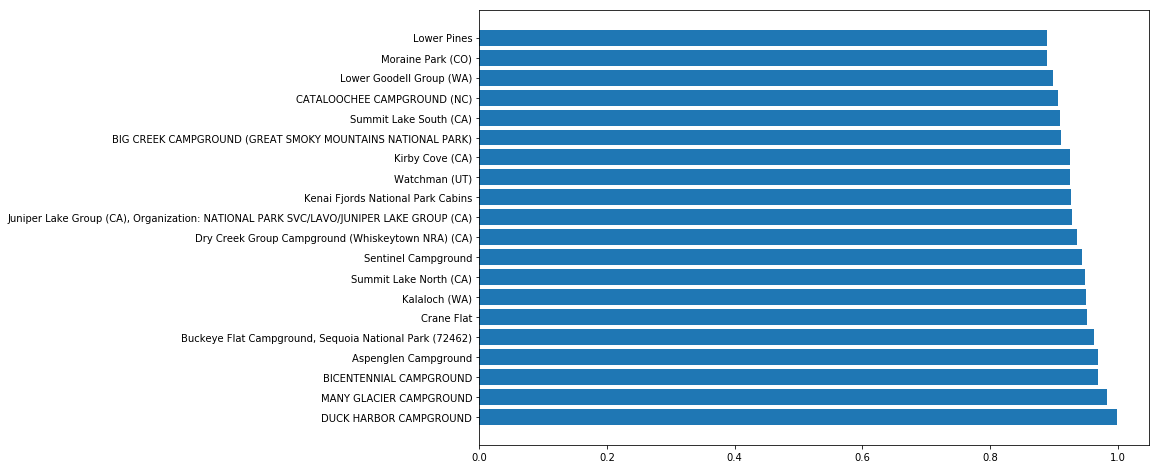

In [59]:
# plot top sites by percent booked
plt.figure(figsize = (12, 8))
plt.barh(pb_group.index, pb_group['PercentBooked'])

In [60]:
# define function to plot daily campsite data
def top_site_data(df, column, by = 'Site'):
    
    df_group = combined_rez.groupby([by]).agg({column: np.mean}).sort_values(by = column, ascending = False).head(20)
    
    plt.figure(figsize = (12, 8))
    plt.barh(df_group.index, df_group[column])

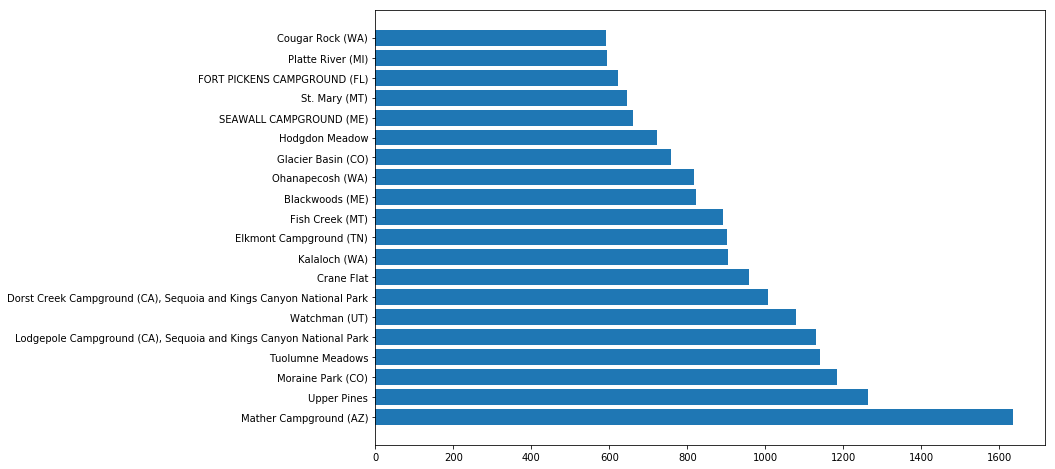

In [61]:
top_site_data(combined_rez, 'NumberOfPeople')

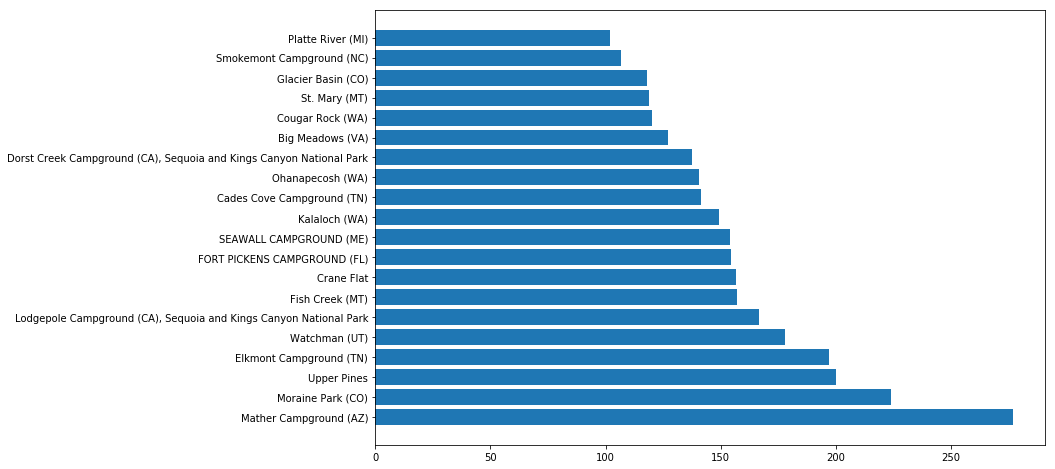

In [62]:
top_site_data(combined_rez, 'SitesBooked')

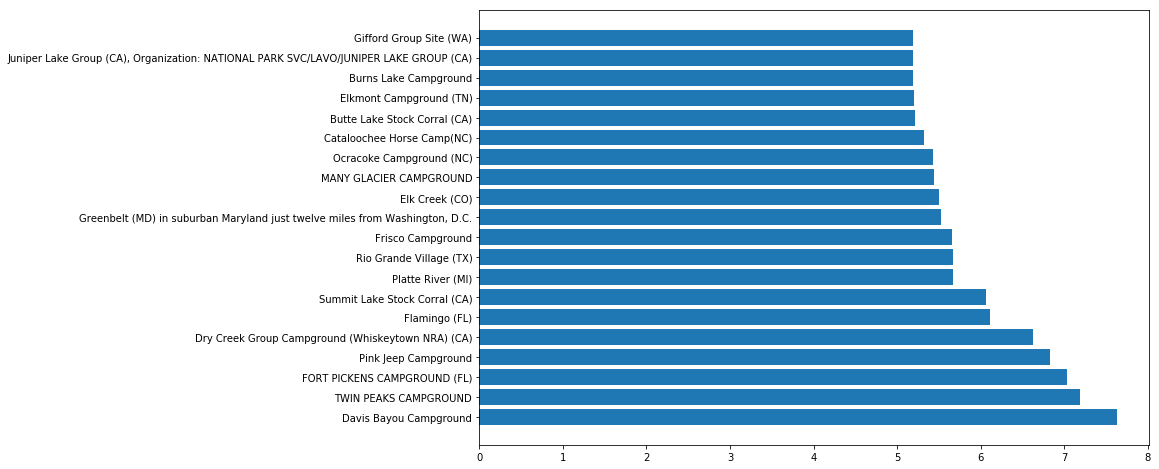

In [63]:
top_site_data(combined_rez, 'AvgStayLen')

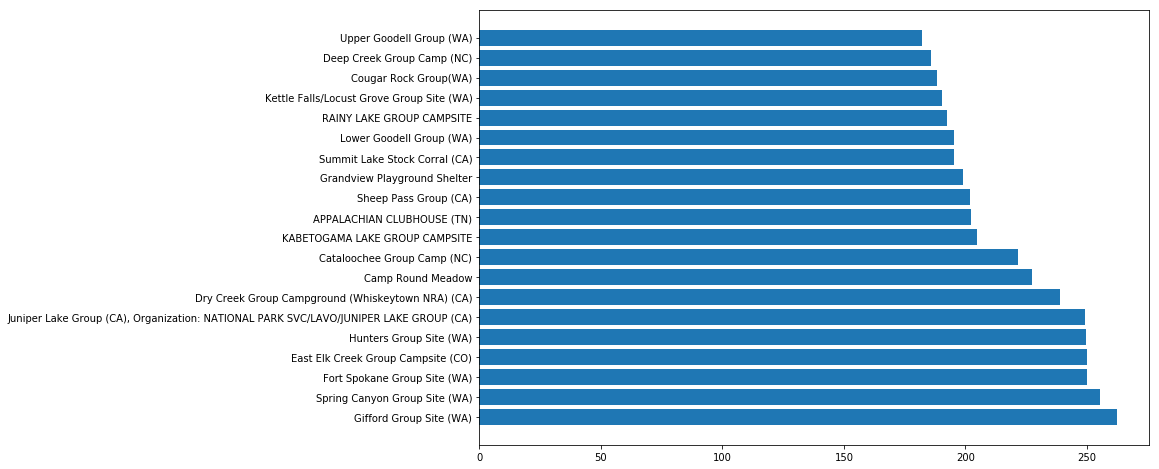

In [64]:
top_site_data(combined_rez, 'AvgBookingHorizon')

In [65]:
cg_target_ids

[232463, 232490, 232447, 232459, 232487, 232508, 234674]

In [66]:
# define function to aggregate sites into a new dataframe
def site_df (df, fid, sites):
    # filter by facility ID, find min and max dates for a a diven site
    new_df = df[df['FacilityID'] == fid]
    idx = pd.date_range(new_df['Date'].min(), new_df['Date'].max())
    
    # use the site data to get uniform facility name and park values
    site_name = sites.loc[sites['FacilityID'] == fid]['Site'].values[0]
    park_name = df.loc[df['FacilityID'] == fid]['Park'].values[0]
    
    # set datetime index, drop duplicate dates, reindex
    new_df.index = pd.DatetimeIndex(new_df['Date'])
    new_df = new_df[~new_df.index.duplicated(keep='first')]
    new_df = new_df.reindex(idx, fill_value = 0)
    
    # establish unfiform site values
    new_df['Site'] = site_name
    new_df['Date'] = new_df.index
    new_df['Park'] = park_name
    new_df['FacilityID'] = fid
    
    return new_df

In [67]:
moraine = site_df(cg_target, 232463, site_data)

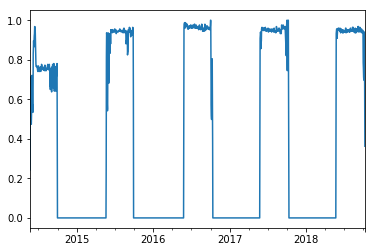

In [68]:
# look at series for moraine
moraine['PercentBooked'].plot()

In [69]:
# plot mather series
mather = site_df(cg_target, 232490, site_data)

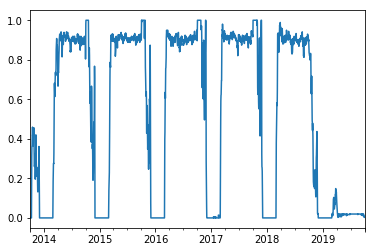

In [70]:
mather['PercentBooked'].plot()

In [71]:
blackwoods = site_df(cg_target, 232508, site_data)

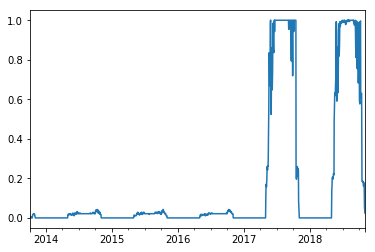

In [72]:
# plot blackwoods series
blackwoods['PercentBooked'].plot()

In [73]:
upper_pines = site_df(cg_target, 232447, site_data)

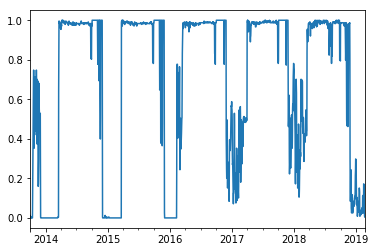

In [74]:
# plot upper pines series
upper_pines['PercentBooked'].plot()

In [75]:
big_meadow = site_df(cg_target, 232459, site_data)

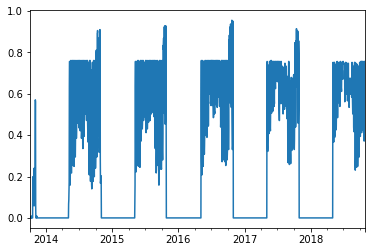

In [76]:
# plot big meadow series
big_meadow['PercentBooked'].plot()

In [77]:
elkmont = site_df(cg_target, 232487, site_data)

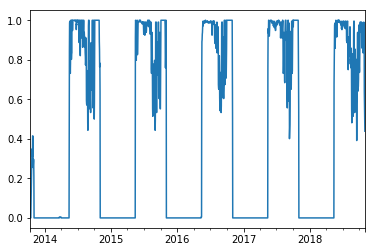

In [78]:
# plot elkmont series
elkmont['PercentBooked'].plot()

In [79]:
seawall = site_df(cg_target, 234674, site_data)

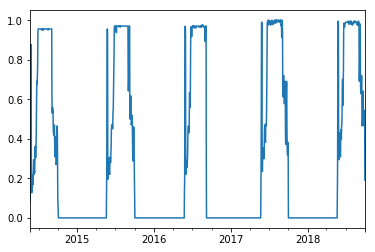

In [80]:
# plot seawall series
seawall['PercentBooked'].plot()

In [81]:
lodgepole = site_df(combined_rez, 232461, site_data)

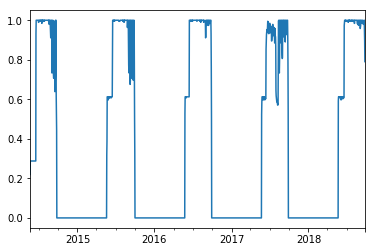

In [82]:
# plot lodgepole series
lodgepole['PercentBooked'].plot()

In [83]:
#export to csv
moraine.to_csv( "./data/Site-Data/moraine_agg.csv", index = False, encoding='utf-8-sig')
mather.to_csv( "./data/Site-Data/mather_agg.csv", index = False, encoding='utf-8-sig')
big_meadow.to_csv( "./data/Site-Data/bigmeadow_agg.csv", index = False, encoding='utf-8-sig')
upper_pines.to_csv( "./data/Site-Data/upperpines_agg.csv", index = False, encoding='utf-8-sig')
blackwoods.to_csv( "./data/Site-Data/blackwoods_agg.csv", index = False, encoding='utf-8-sig')
elkmont.to_csv( "./data/Site-Data/elkmont_agg.csv", index = False, encoding='utf-8-sig')
seawall.to_csv( "./data/Site-Data/seawall_agg.csv", index = False, encoding='utf-8-sig')
lodgepole.to_csv( "./data/Site-Data/lodgepole_agg.csv", index = False, encoding='utf-8-sig')